## This notebook was created to explore the effect of two parameters:
#### 1. ccpsplit
#### 2. mergeThreshold
### on the resulting units identified by kilosort2 [by Marius Pachitariu]
<br></br>
imports

In [85]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
import pandas as pd
import os,glob
import _pickle as pkl
import seaborn as sns
import urllib.request as request
import dropbox

sns.set_style("ticks")
plt.style.use("dark_background")
matplotlib.rcParams.update({'font.size': 22})
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<br></br>
<br></br>
### The same data was sorted, using a range of ccsplit and mergeThreshold values
- the data set is from one of Dan's recordings, an angled insertion through V1, subiculum, and dLGN
    - data can be found locally here: /Volumes/SD1/DanD/M319891/31082017/M319891_2017-08-31_08-50-22_angled_to3.7/
- none of the kilosort2 outputs were manually modified in phy, these are straight unsupervised outputs

#### Here we get the sorting quality results, which have been precomputed
the data are put into a dictionary called 'data' with entries for each parameter; also a DataFrame

In [86]:
directory = '/Users/danieljdenman/Desktop/data/ks2_testing/'
params = ['ccsplit','mt']
data = {};dfs = {}
parameter_l = [];valuef=[];values = [];overmerged_all=[];overmerged=[];SN=[];isiV=[];unit=[]
for param in params:
    data[param]={}
    for results_path in glob.glob(directory+param+'*'):
        results = pkl.load(open(results_path,'rb'),encoding='bytes')
        value = float('0.'+os.path.basename(results_path).strip('.pkl').split('0')[1].strip('p'))
        data[os.path.basename(results_path).strip('.pkl').split('0')[0]][value]=results
        for i,c in enumerate(results[b'SN'][0]):
            parameter_l.extend([param]);valuef.extend([value]);values.extend([str(value)]);overmerged_all.extend([results[b'overmerged_all'][i]]);overmerged.extend([results[b'overmerged'][i]]);SN.extend([results[b'SN'][1][i]]);isiV.extend([results[b'isiV'][1][i]]);unit.extend([results[b'SN'][0][i]])
df=pd.DataFrame({'parameter':parameter_l,'values':values,'valuef':valuef,'overmerged_all':overmerged_all,'overmerged':overmerged,'SN':SN,'isiV':isiV,'unit':unit})


<br></br>
<br></br>
## Look at how ccsplit and mergeThreshold parameters affect various outputs
<br></br>
the total number of units kilosort2 finds:

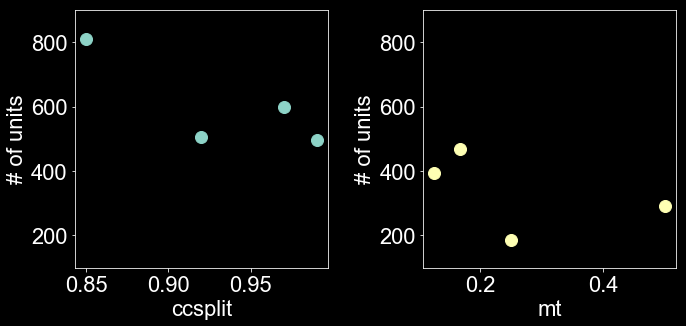

In [87]:
f,ax=plt.subplots(1,2,figsize=(10,5))
for param in params:
    axis = ax[params.index(param)]
    axis.plot(data[param].keys(),[data[param][val][b'isiV'][0].shape[0] for val in data[param].keys()],'o',ms=12,color=sns.color_palette()[params.index(param)]);
    axis.set_ylim(100,900)
    axis.set_xlabel(param);axis.set_ylabel('# of units')
plt.tight_layout()


<br></br>
the rate of ISI violation within the units kilosort2 finds:

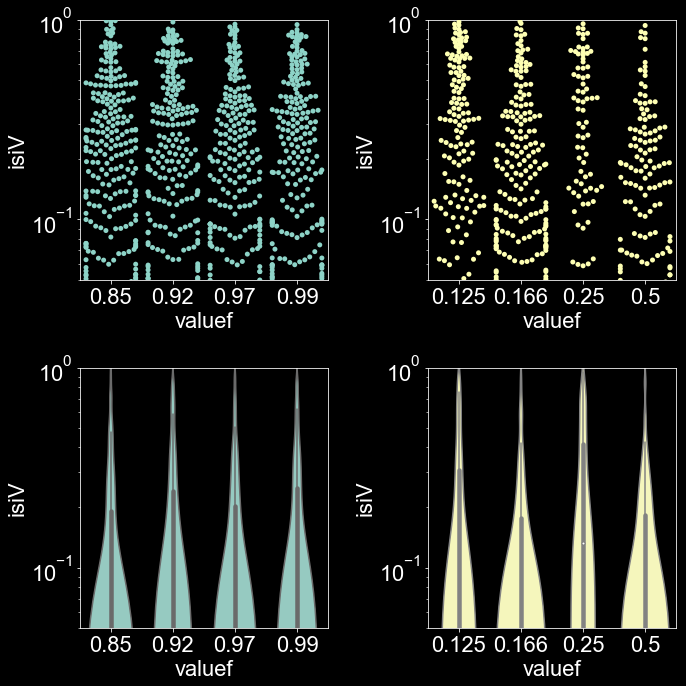

In [88]:
f,ax=plt.subplots(2,2,figsize=(10,10))
for param in params:
    axis = ax[:,params.index(param)]
    dft = df[df.parameter==param][df.isiV<.99]
    sns.swarmplot(x='valuef',y='isiV',data=dft,ax=axis[0],color=sns.color_palette()[params.index(param)])
    sns.violinplot(x='valuef',y='isiV',data=dft,ax=axis[1],color=sns.color_palette()[params.index(param)])
for axis in ax.flatten(): axis.set_yscale('log')
for axis in ax.flatten(): axis.set_ylim(0.05,1.)

plt.tight_layout()


<br></br>
<br></br>
### Based on manual inspection of early kilosort2 runs, we created a new sorting metric which assess the extent of "overmerging" - by measuring the amplitude modes.
 - to do so, the recording is broken into 5 minute chunks and the deviance from a unimodal distribution
 - the 90th percentile [most bimodal] is taken as the "overmergedness" of this cluster
<br></br>
Here, are see two units, one overmerged and one not:

In [102]:
def show_overmergedness(unit,spike_clusters,spike_times,amplitudes):
    f,ax=plt.subplots(1,2,figsize=(8,5))
    chunks = np.ceil((spike_times[-1][0]-spike_times[0][0])/(30000*300))
    for chunk in range(int(chunks-1)):
        chunk_times = spike_times[spike_clusters==unit].flatten()[\
                        np.where((spike_times[spike_clusters==unit].flatten() < (chunk+1) * (30000*300)) &\
                                 (spike_times[spike_clusters==unit].flatten() > chunk * (30000*300)))]
        chunk_amps = amplitudes[spike_clusters==unit].flatten()[\
                        np.where((spike_times[spike_clusters==unit].flatten() < (chunk+1) * (30000*300)) &\
                                 (spike_times[spike_clusters==unit].flatten() > chunk * (30000*300)))]
        ax[0].plot(chunk_times,chunk_amps,'o',ms=0.2)
        h,e = np.histogram(chunk_amps,range=(0,40),bins=40)
        peak = np.min(np.where(h == np.max(h)))
        e = e-peak
        ax[1].bar(e[1:],h,width=1,alpha=0.2)

In [ ]:
a=request.urlopen('https://www.dropbox.com/s/d3cshzw96elxgmb/amplitudes.npy?dl=1')
a2=a.read()
a.close()
with open('amplitudes.npy', "wb") as f :
    f.write(a2)       
amplitudes = np.load('amplitudes.npy')
a=request.urlopen('https://www.dropbox.com/s/9zwefzwtliht8q5/spike_clusters.npy?dl=1')
a2=a.read()
a.close()
with open('spike_clusters.npy', "wb") as f :
    f.write(a2)      
spike_clusters = np.load('spike_clusters.npy')
a=request.urlopen('https://www.dropbox.com/s/h2stt9r3paip79n/spike_times.npy?dl=1')
a2=a.read()
a.close()
with open('spike_times.npy', "wb") as f :
    f.write(a2)      
spike_times = np.load('spike_times.npy')

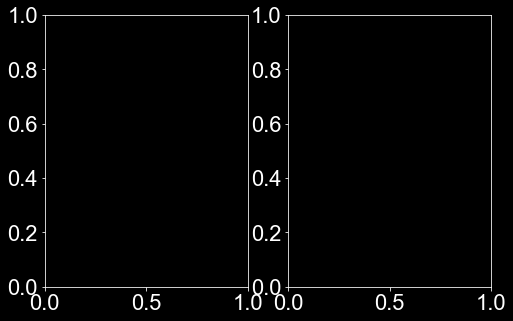

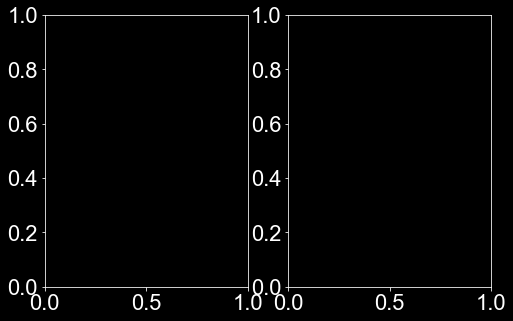

In [107]:
unit=351;show_overmergedness(unit,spike_clusters,spike_times,amplitudes)
unit=13;show_overmergedness(unit,spike_clusters,spike_times,amplitudes)

- each of these plots shows the 5 minute chunks in a different color
- the corresponding amplitude histogram is shown in that color
- the unimodality test is the [Hartigan dip test](http://projecteuclid.org/euclid.aos/1176346577) from [this package](https://github.com/tatome/dip_test)

### the overall distribution of "overmergedness" looks like this, for a single recording:

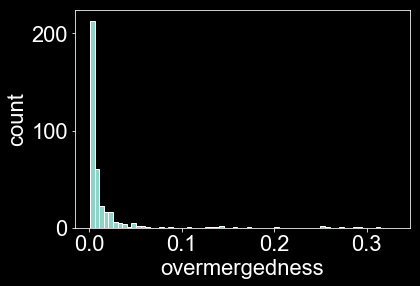

In [71]:
d=plt.hist(df.overmerged[df.parameter=='ccsplit'][df.valuef==0.92],range=(0.001,.33),bins=66)
d=plt.ylabel('count');d=plt.xlabel('overmergedness')

### "overmergedgess" depends a bit on ccsplit and mergeThreshold

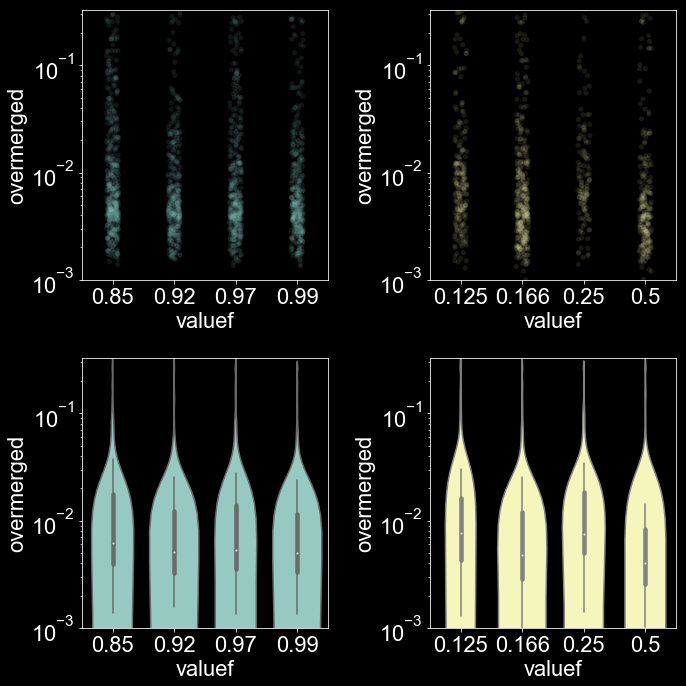

In [75]:
f,ax=plt.subplots(2,2,figsize=(10,10))
for param in params:
    axis = ax[:,params.index(param)]
    dft = df[df.parameter==param]
    sns.stripplot(x='valuef',y='overmerged',data=dft,ax=axis[0],color=sns.color_palette()[params.index(param)],alpha=0.1)
    sns.violinplot(x='valuef',y='overmerged',data=dft,ax=axis[1],color=sns.color_palette()[params.index(param)])
for axis in ax.flatten(): axis.set_yscale('log')
for axis in ax.flatten(): axis.set_ylim(0.001,.33)

d=plt.tight_layout()

